## Small Business Loans: Exploratory Data Analysis

In [1]:
import pandas as pd 
import numpy as np
import datetime as dt
import seaborn as sns
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import proportions_chisquare
from statsmodels.stats.proportion import proportions_chisquare_allpairs

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("../Data/Processed/sba_cleaned.csv")

## Preparing the Data

To start, we load in the cleaned data from our initial data wrangling.

In [3]:
## Recall the feature names from our data.
df.columns

Index(['ID', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState', 'NAICS',
       'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist', 'CreateJob',
       'RetainedJob', 'FranchiseCode', 'UrbanRural', 'LowDoc', 'ChgOffDate',
       'DisbursementDate', 'DisbursementGross', 'BalanceGross', 'MIS_Status',
       'ChgOffPrinGr', 'GrAppv', 'SBA_Appv'],
      dtype='object')

In [4]:
df.shape

(896106, 26)

Since csv format does not keep track of data stypes, we must examine those and reset as needed.

In [5]:
## Examine the data types.
df.dtypes

ID                     int64
Name                  object
City                  object
State                 object
Zip                    int64
Bank                  object
BankState             object
NAICS                float64
ApprovalDate          object
ApprovalFY            object
Term                   int64
NoEmp                  int64
NewExist             float64
CreateJob              int64
RetainedJob            int64
FranchiseCode          int64
UrbanRural             int64
LowDoc                object
ChgOffDate            object
DisbursementDate      object
DisbursementGross    float64
BalanceGross         float64
MIS_Status            object
ChgOffPrinGr         float64
GrAppv               float64
SBA_Appv             float64
dtype: object

In [6]:
## Columns to be converted to categories
cat_cols = ['ID', 'Name','State', 'City', 'NAICS', 'Zip', 'Bank', 'BankState', 'FranchiseCode', 'NewExist', 'UrbanRural', 'LowDoc', 'MIS_Status']
df[cat_cols] = df[cat_cols].apply(lambda x: x.astype('category'))

There are are a large number of NAICS codes, which may create memory issues with encoding. However, the first two digits of the NAICS code keeps track of the overeall type of industry. We simplify by replacing NAICS code with its first two digits.

In [7]:
## First two digits of each industry code
df['Industry'] = df['NAICS'].apply(lambda x: str(x)[:2])

In [8]:
df['Industry'] = df['Industry'].astype('category')

In [9]:
df = df.dropna(subset=['MIS_Status'])

In [10]:
## Create a column 'Default' which records whether a loan went into default or not
## as a boolean. This allows us to compute the proportion of defaults by averaging
## values in the default column
df['Default'] = ((df['MIS_Status'] == 'CHGOFF'))

## Default Rate by Categorical Variables

We will compare default rates by categorical variables. We investigate:
 
- Whether a business is new or existing
- Whether a business is urban or rural
- Whether a business is part of a franchise 
- State where a business is located
- Type of industry

 ### New vs. existing business

In [11]:
by_age = df[['NewExist', 'Default']].groupby('NewExist').agg(['mean', 'sum', 'count'])
by_age = by_age.rename(index={1: "Existing", 2: "New"}, columns={'mean' :'default rate',
                                                       'sum': 'defaults',
                                                       'count': 'loans'})
by_age

Default                 
         default rate defaults   loans
NewExist                              
Existing     0.170216   109396  642688
New          0.186672    47090  252260

It appears that the default rate is slightly lower for existing businesses than for new ones, but it is not clear if that difference is significant. We investigate with a hypothesis test.

In [12]:
count = by_age[('Default', 'defaults')]
nobs = by_age[('Default', 'loans')]
stat, pval = proportions_ztest(count, nobs, alternative = 'smaller')
print(stat)
print('p-value for two-sample test comparing proportions: ' + '{0:0.3f}'.format(pval))

-18.439507999811266
p-value for two-sample test comparing proportions: 0.000


Our hypothesis test suggests that the observed difference, while small, is significant.

### Urban vs. Rural Businesses

In [13]:
by_location = df[['UrbanRural', 'Default']].groupby('UrbanRural').agg(['mean', 
                                                                       'sum', 'count'])
by_location = by_location.rename(index={1: "Urban", 
                          2: "Rural", 
                          0: "Undefined"}, columns={'mean' :'default rate',
                                                    'sum' : 'defaults',
                                                    'count': 'loans'})
by_location

Default                 
           default rate defaults   loans
UrbanRural                              
Undefined      0.068307    21979  321767
Urban          0.244773   114867  469279
Rural          0.187636    19713  105060

It appears that urban businesses are slightly more likely to default than rural, while businesses coded as `Undefined` have dramatically lower default rates. This is an interesting finding, but it's unclear how to interpret the `Underfined` entries--which account for more than a third of the data. Are these businesses from smaller towns and suburbs, which do not fit either the `Urban` or `Rural` categories? Or are they missing values--making this entire column much less useful!

Let's run a hypothesis test to compare the default rates between groups. Since we have three groups instead of two, we use the $\chi$-squared test, and compare all three groups. Once again, all $p$-values are $0$, suggesting that the three groups all all significantly different from each other.

In [14]:
df.loc[df['UrbanRural']==0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 321767 entries, 0 to 896105
Data columns (total 28 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   ID                 321767 non-null  category
 1   Name               321760 non-null  category
 2   City               321737 non-null  category
 3   State              321755 non-null  category
 4   Zip                321767 non-null  category
 5   Bank               320291 non-null  category
 6   BankState          320285 non-null  category
 7   NAICS              144055 non-null  category
 8   ApprovalDate       321767 non-null  object  
 9   ApprovalFY         321767 non-null  object  
 10  Term               321767 non-null  int64   
 11  NoEmp              321767 non-null  int64   
 12  NewExist           321263 non-null  category
 13  CreateJob          321767 non-null  int64   
 14  RetainedJob        321767 non-null  int64   
 15  FranchiseCode      321767 non-null

In [15]:
count = by_location[('Default', 'defaults')]
nobs = by_location[('Default', 'loans')]
print(proportions_chisquare_allpairs(count, nobs))

Corrected p-values using Holm-Sidak p-value correction

Pairs  p-values
(0, 1)       0
(0, 2)       0
(1, 2)       0


### Franchise vs. non-Franchise Business

In [16]:
df['Franchise'] = df['FranchiseCode'] != 0

In [17]:
df_franchise = df[['Franchise', 
                   'Default']].groupby('Franchise').agg(['mean',
                                                         'sum', 'count'])
df_franchise = df_franchise.rename(columns={'mean' :'default rate',
                                            'sum' : 'defaults',
                                            'count' : 'loans'})
df_franchise

Default                 
          default rate defaults   loans
Franchise                              
False         0.176145   148740  844417
True          0.151270     7819   51689

It appears that businesses which are part of a franchise are slightly less likely to default than standalone businesses. Let's try a hypothesis test to confirm! We use a two-sample `z`-test, with the alternative hypothesis that the default rate is larger for non-franchise businesses.

In [18]:
count = df_franchise[('Default', 'defaults')]
nobs = df_franchise[('Default', 'loans')]
stat, pval = proportions_ztest(count, nobs, alternative = 'larger')
print('p-value for two-sample test comparing proportions: ' + '{0:0.3f}'.format(pval))

p-value for two-sample test comparing proportions: 0.000


Once again, the difference is statistically significant!

### Differences by State

We now investigate differences by state. For the figures in this section and the next, I followed a code example created by Michael Waskom, which may be found here:
https://seaborn.pydata.org/examples/part_whole_bars.html

We see that there are large differences among states in both number of loans, and default rates. California has by far the most loans of any state, followed by Texas, New York, and Florida. Florida has the highest default rate, followed by Georgia, Washington DC, Nevada, and Illinois. Since DC has so few loans overall, the high default rates in DC may not be terribly relevant for our final model.

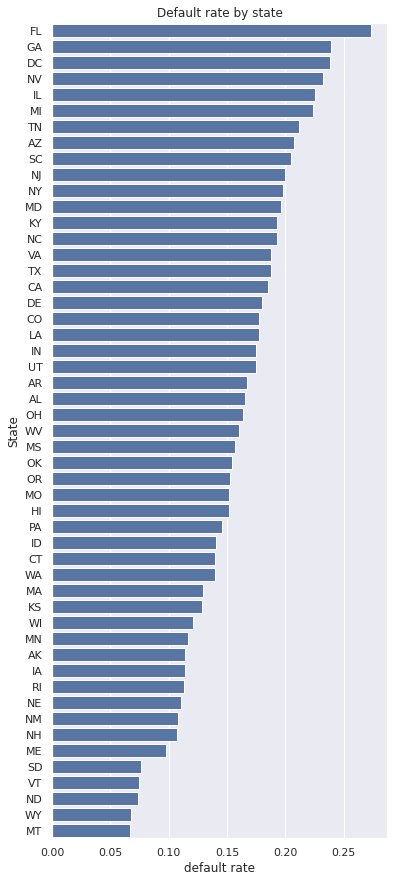

In [19]:
by_state = df[['Default', 'State']].groupby('State').agg(['mean', 'count', 'sum'])
by_state.columns = ['default rate', 'loans', 'defaults']
by_state.reset_index(level=0, inplace=True)

sns.set()
f, ax = plt.subplots(figsize=(6, 15))
sns.set_color_codes('deep')
_ = sns.barplot(x='default rate', y='State', data=by_state, 
            order=by_state.sort_values('default rate', ascending=False).State,
            color='b')
ax.set(title = 'Default rate by state')
plt.show()

A quick $\chi$-squared test shows that there are statistically significant differences among the states.

In [20]:
count = by_state['defaults']
nobs = by_state['loans']
stat, pval, table = proportions_chisquare(count, nobs)
pval

0.0

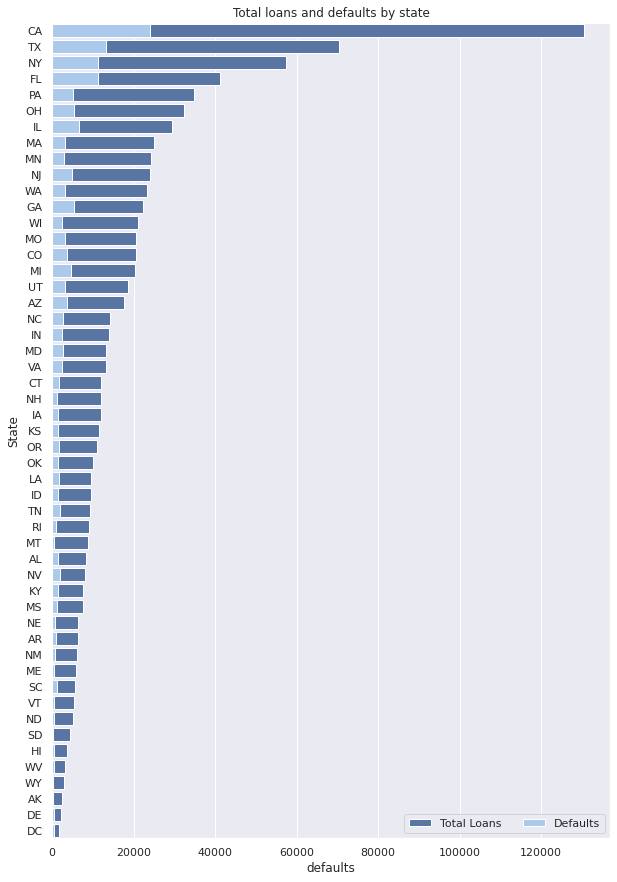

In [21]:
f, ax = plt.subplots(figsize=(10, 15))

# Plot the total loans
sns.set_color_codes("deep")
sns.barplot(x="loans", y="State", data=by_state,
            order = by_state.sort_values('loans', ascending=False).State,
            label="Total Loans", color="b")

# Plot the loans which defaulted
sns.set_color_codes("pastel")
sns.barplot(x="defaults", y="State", data=by_state,
            order = by_state.sort_values('loans', ascending=False).State,
            label="Defaults", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(title='Total loans and defaults by state')
plt.show()

### Differences by industry

We observe significant differences by industry as well. The highest default rates are in industries with code 53 (real estate andrental leasing) and 52 (finance and insurance). This is followed closely by Sector 48 (transportation and warehousing). All three have default rates above 25%. 

The lowest default rates are in Sector 21 (mining, quarrying, oil and gas extraction) and Sector 11 (agricultural, forestry, fishing and hunting) and Sector 55 (management of companies and enterprises.) We note, however, the Sectors 21 and 55 account  for very few loans overall. Sector 62 (healthcare and social assistance) enjoys a low default rate (just over 10%), while accounting for a substantial share of loans.

Perhaps unsurprisingly, the sector accounting for the largest number of loans was Sector 44 (retail trade). The second largest share came from Sector 81 (other services), a catch-all that includes automotive, appliance and electronic repair; personal services such as hairdressing; and civic, professional and religious organizations.

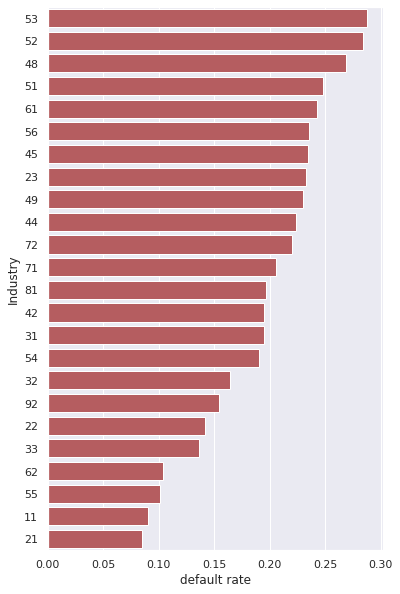

In [22]:
by_industry = df[['Default', 'Industry']].groupby('Industry').agg(['mean', 'count', 'sum'])
by_industry.columns = ['default rate', 'loans', 'defaults']
by_industry.reset_index(level=0, inplace=True)

sns.set()
f, ax = plt.subplots(figsize=(6, 10))
sns.set_color_codes('deep')
_ = sns.barplot(x='default rate', y='Industry', data=by_industry, 
            order=by_industry.sort_values('default rate', ascending=False).Industry,
            color='r')

A hypothesis test shows there are statistically significant differences in default rates by industry.

In [23]:
count = by_industry['defaults']
nobs = by_industry['loans']
stat, pval, table = proportions_chisquare(count, nobs)
pval

0.0

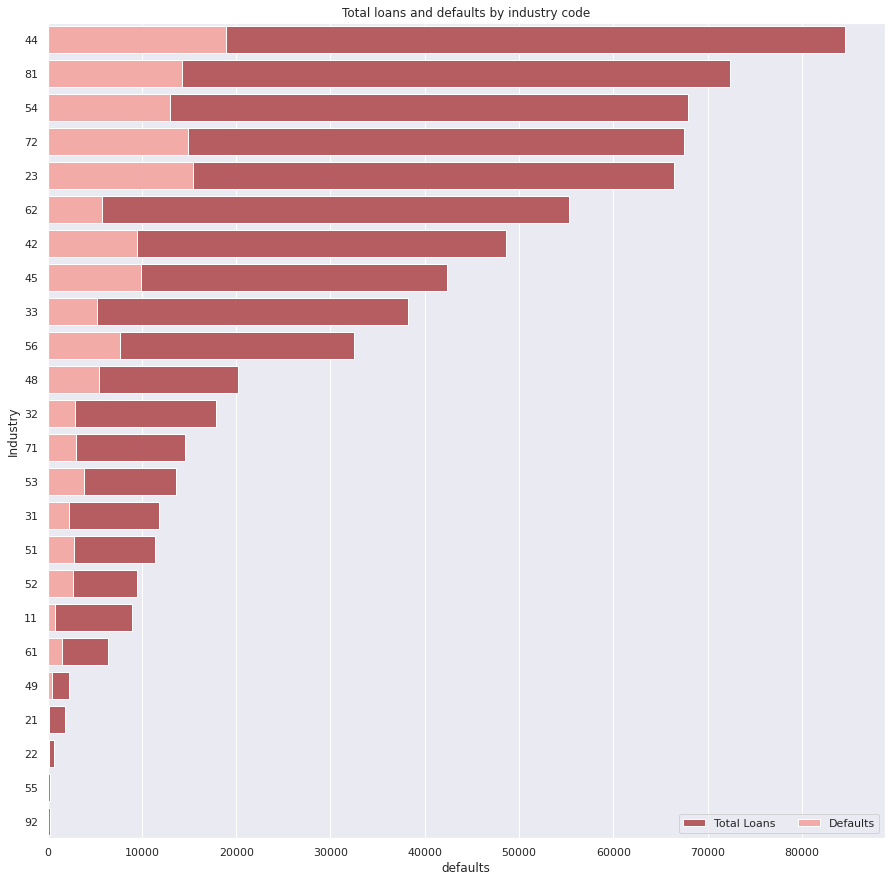

In [24]:
f, ax = plt.subplots(figsize=(15, 15))

# Plot the total loans
sns.set_color_codes("deep")
sns.barplot(x="loans", y="Industry", data=by_industry,
            order = by_industry.sort_values('loans', ascending=False).Industry,
            label="Total Loans", color="r")

# Plot the crashes which went into default
sns.set_color_codes("pastel")
sns.barplot(x="defaults", y="Industry", data=by_industry,
            order = by_industry.sort_values('loans', ascending=False).Industry,
            label="Defaults", color="r")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(title='Total loans and defaults by industry code')
plt.show()

## Default Rates by Quantitative Variables

We will investigate the following variables.

* Length of the loan in months (coded `Term`)
* Number of employees at the business (`NoEmp`)
* Total loan amount (`GrAppv`)
* Amount guaranteed by the SBA (`SBA_Appv`)

### Loan Term

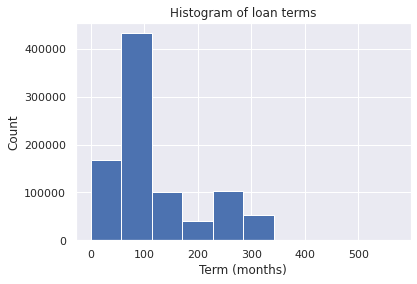

In [25]:
plt.hist(df['Term'])
plt.xlabel('Term (months)')
plt.ylabel('Count')
plt.title('Histogram of loan terms')
plt.savefig('../Reports/Figures/term_hist.svg')
plt.show()

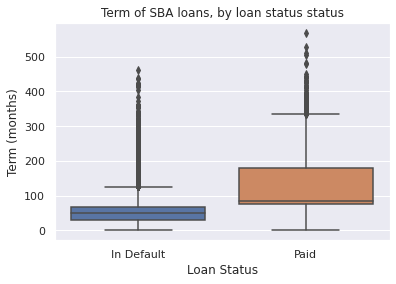

In [26]:
_ = sns.boxplot(x='MIS_Status', y='Term', data=df)
_.set(xlabel='Loan Status')
plt.xticks([0,1], ['In Default', 'Paid'])
plt.ylabel('Term (months)')
plt.title('Term of SBA loans, by loan status status')
plt.savefig('../Reports/Figures/term.svg')
plt.show()

The distribution of loan terms is skewed, but not so badly that the histogram is unreadable. Examining our box plot, it appears that loans in default tend to have shorter loan-terms, suggesting that a shorter is associated with a higher probability of default. We confirm this with a hypothesis test.

In [27]:
default = df.loc[df['MIS_Status']=='CHGOFF', 'Term']
paid = df.loc[df['MIS_Status']=='P I F', 'Term']
stat, pval, degf = ttest_ind(default, paid, 
                             alternative='smaller', usevar='unequal', value=0)
print('p-value for two-sample t-test: ' + '{0:0.3f}'.format(pval))

p-value for two-sample t-test: 0.000


### Number of Employees

We found in the data cleaning phase that number of employees is extremely skewed. To compensate, we apply a log transform. The resulting distribution is still somewhat skewed, but not unreasonably so.

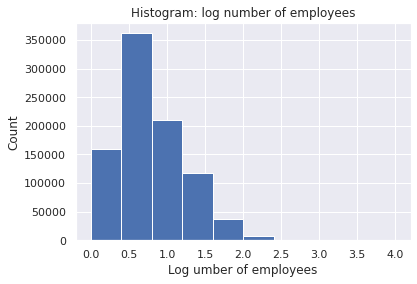

In [28]:
## We take the base-10 logarithm of number of employees, after adding 1
## to make sure the logarithm is defined.
df_emp = df.loc[:, ['MIS_Status', 'NoEmp']]
df_emp['log_emp'] = np.log10(df_emp['NoEmp']+1)

## A histogram show that the resulting distribution has less of a right skew
plt.hist(df_emp['log_emp'])
plt.ylabel("Count")
plt.xlabel("Log umber of employees")
plt.title("Histogram: log number of employees")
plt.show()

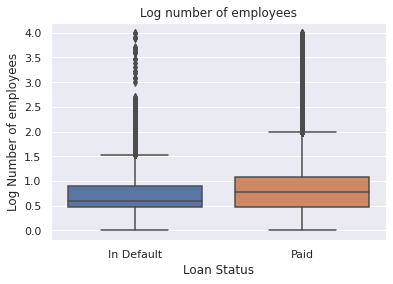

In [29]:
_ = sns.boxplot(x='MIS_Status', y='log_emp', data=df_emp)
_.set(xlabel='Loan Status')
plt.xticks([0,1], ['In Default', 'Paid'])
plt.ylabel('Log Number of employees')
plt.title('Log number of employees')
plt.show()

From the box plots, seems that businesses who default on their loans
tend to have fewer employees, on average. It is not clear if this is a meaningful difference. We try a `t`-test, remembering that we are performing a hypothesis test on the transformed data. This shows the difference in means for the scaled data is significant.

In [30]:
default = df_emp.loc[df['MIS_Status']=='CHGOFF', 'log_emp']
paid = df_emp.loc[df['MIS_Status']=='P I F', 'log_emp']
stat, pval, degf = ttest_ind(default, paid, 
                             alternative='smaller', usevar='unequal', value=0)
print('p-value for two-sample t-test: ' + '{0:0.3f}'.format(pval))

p-value for two-sample t-test: 0.000


### Total amount approved

We now consider total amount of the loan. Once again, we plot this on a log scale. The resulting histogram has a mound-shaped distribution which is close to symmetric, suggesting that loan ammount may follow an approximately log-normal distribution.

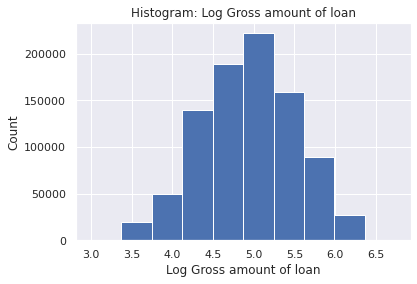

In [31]:
## We take the base-10 logarithm of gross amount approved.
## to make sure the logarithm is defined.
df_Gr = df.loc[:, ['MIS_Status', 'GrAppv']]
df_Gr['log_gr'] = np.log10(df_Gr['GrAppv'])

## A histogram show that the resulting distribution is nearly symmetric.
plt.hist(df_Gr['log_gr'])
plt.ylabel("Count")
plt.xlabel("Log Gross amount of loan")
plt.title("Histogram: Log Gross amount of loan")
plt.show()

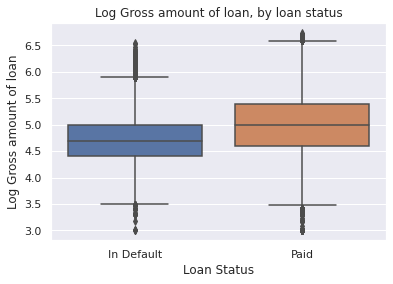

In [32]:
_ = sns.boxplot(x='MIS_Status', y='log_gr', data=df_Gr)
_.set(xlabel='Loan Status')
plt.xticks([0,1], ['In Default', 'Paid'])
plt.ylabel('Log Gross amount of loan')
plt.title('Log Gross amount of loan, by loan status')
plt.show()

It appears that paid-off loans appear to have somewhat higher loan amounts. This is reasonable, as financial institutions may give larger loans to businesses that are doing well. Once again, a two-sample `t`-test confirm the difference in means for the scaled data is significant.

In [33]:
default = df_Gr.loc[df['MIS_Status']=='CHGOFF', 'log_gr']
paid = df_Gr.loc[df['MIS_Status']=='P I F', 'log_gr']
stat, pval, degf = ttest_ind(default, paid, 
                             alternative='smaller', usevar='unequal', value=0)
print('p-value for two-sample t-test: ' + '{0:0.3f}'.format(pval))

p-value for two-sample t-test: 0.000


### Amount guaranteed by SBA

Finally, we consider amount guaranteed by the SBA. Once again, we see that this appears to follow an approximately log-normal distribution.

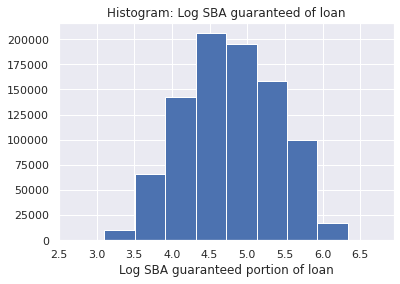

In [34]:
## We take the base-10 logarithm of gross amount approved.
## to make sure the logarithm is defined.
df_SBA = df.loc[:, ['MIS_Status', 'SBA_Appv']]
df_SBA['log_sba'] = np.log10(df_SBA['SBA_Appv'])

## A histogram show that the resulting distribution is nearly symmetric.
plt.hist(df_SBA['log_sba'])
plt.xlabel("Log SBA guaranteed portion of loan")
plt.title("Histogram: Log SBA guaranteed of loan")
plt.show()

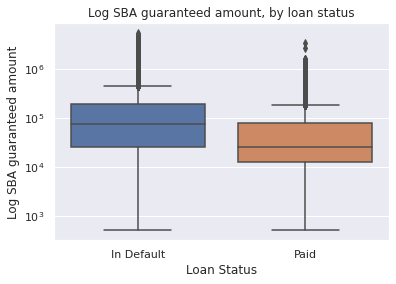

In [35]:
## Plot
_ = sns.boxplot(x='Default', y='SBA_Appv', data=df)
_.set(xlabel='Loan Status')
plt.yscale('log')
plt.xticks([0,1], ['In Default', 'Paid'])
plt.ylabel('Log SBA guaranteed amount')
plt.title('Log SBA guaranteed amount, by loan status')
plt.show()

Unsurprisingly, loans that end up in default tend to have lower guaranteed amounts. A hypothesis test confirms this.

In [36]:
default = df_SBA.loc[df['MIS_Status']=='CHGOFF', 'log_sba']
paid = df_SBA.loc[df['MIS_Status']=='P I F', 'log_sba']
stat, pval, degf = ttest_ind(default, paid, 
                             alternative='smaller', usevar='unequal', value=0)
print('p-value for two-sample t-test: ' + '{0:0.3f}'.format(pval))

p-value for two-sample t-test: 0.000


## Default Rates by Year Approved

We first look at the distribution of approval years. It seems that we have very little data for years before about 1988 or after 2012. It may make sense to narrow our focus to a time span for which we have more data--say, from 1990 to 2010. 

In [37]:
df['ApprovalFY'] = (pd.to_datetime(df['ApprovalFY']))
df['year'] = df['ApprovalFY'].apply(lambda x: x.year)

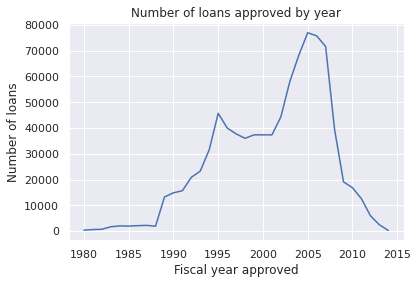

In [38]:
by_year = df.groupby('year')['ID'].count()
## Plot the number of loans approved per year. We see a large spike in the mid-2000's. 
## There is very little data for the 1980's, or for after 2010.
by_year.plot(ylabel = 'Proportion of loans defaulted')
plt.title('Number of loans approved by year')
plt.xlabel('Fiscal year approved')
plt.ylabel('Number of loans')
plt.show()

Next, we plot default rate by year. Default rates are extremely high for loans approved in the early 80's, relatively low for loans approved in the late 80's through early 2000's, and spike again for loans approved in the mid-late 2000's. The numbers fomr the 1980's may be due to missing data, or to initial difficulties establishing the SBA loan program. The low default rates for loans approved in the late 80's and 90's, and the spike for loans in the mid-2000's, may be due to changing economic conditions.

The variation year-to-year is a potential concern for our model, suggesting that a model which only considers the characteristics of the business itself may have limited success rate. As we cannot predict economic conditions in advance, this is a serious problem.

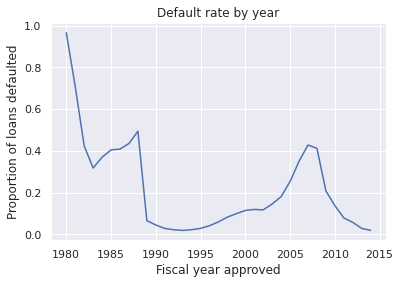

In [39]:
by_year = df.groupby('year')['Default'].mean()
## Plot default rates by year. We see that there is a large spike for loans approved in mid-80's, 
## and another large one for loans approved in the late 2000's.
by_year.plot(ylabel = 'Proportion of loans defaulted')
plt.title('Default rate by year')
plt.xlabel('Fiscal year approved')
plt.show()

We include a second plot zooming in on the years 1990-2010, which seem to account for most of our data.

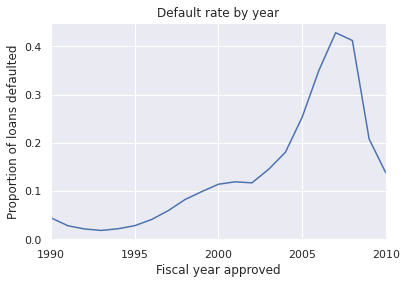

In [40]:
by_year = df.loc[(df['ApprovalFY'] >= pd.to_datetime('1990-01-01')) & 
                 (df['ApprovalFY'] <= pd.to_datetime('2010-01-01'))].groupby('ApprovalFY')['Default'].mean()
## Zoom in on the date range 1990-2010
by_year.plot(ylabel = 'Proportion of loans defaulted')
plt.title('Default rate by year')
plt.xlabel('Fiscal year approved')
plt.savefig('../Reports/Figures/year.svg')
plt.show()

It would be good to have some test for statistical significance here--what methods might be suitable?

## Correlations between numerical features

Having explored the relationship between each variable and default rate, we now plot a heatmap of correlations between all numerical variables. Most variables are not terribly correlated with each other, but a few correlations among relevant predictors stand out. 

Size of loan has a positive correlation with term. Total amount of loan is almost 100% correlated with amount approved by the SBA. Term of loan correlates negatively with approval year, suggesting the SBA has tended to approve shorter loan terms over time.

In [41]:
import seaborn as sns

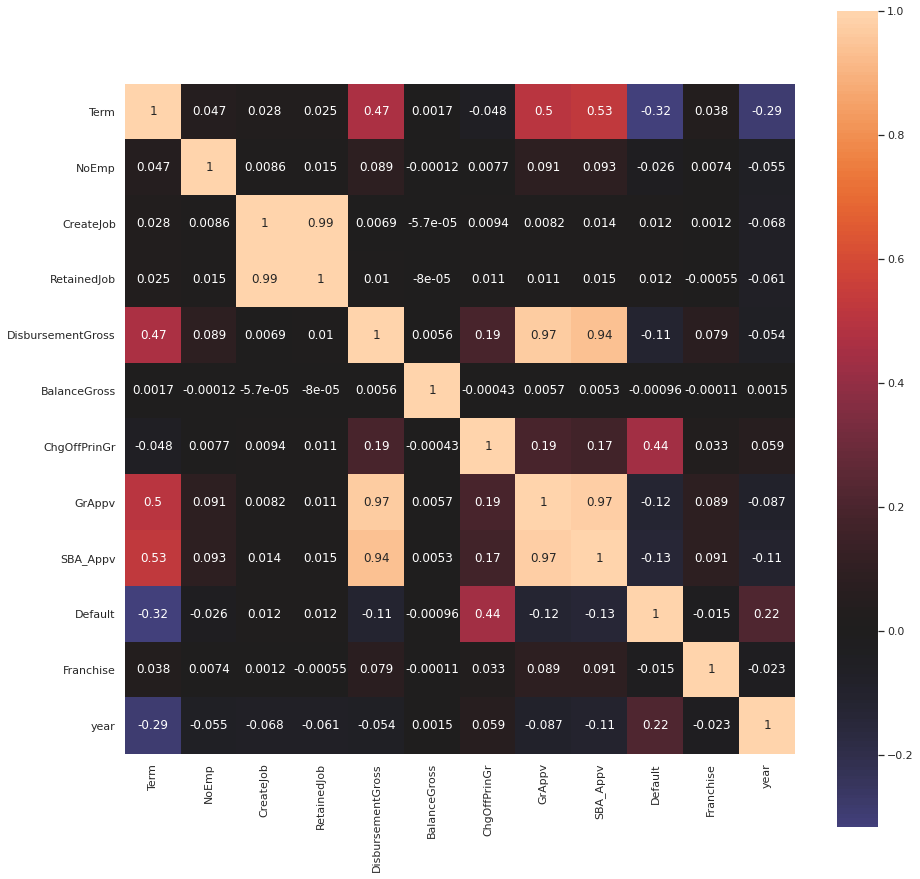

In [42]:
## plot heatmap of correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), center=0, annot=True, square=True)
plt.show()

We saw above that amount guaranteed by the SBA was almost 100% correlated with total loan amount. Are these two features redundant? The plot below shows that they may not be. We plot total amount of loan against amount approved by the SBA, color points according to whether the loan went into default. It appears that default becomes more common as we move further below the line `y=x` in the plot: that is, for loans where a smaller proportion was guaranteed by the SBA.

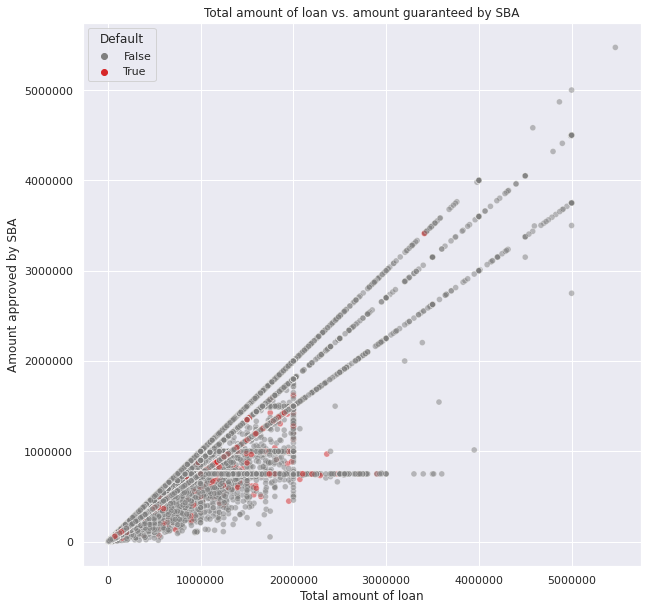

In [43]:
plt.figure(figsize=(10, 10))
palette={
    True: 'tab:red',
    False: 'tab:gray'
}
sns.scatterplot(x='GrAppv', y='SBA_Appv', hue='Default', data=df, palette=palette, alpha=0.5)
plt.xlabel('Total amount of loan')
plt.ylabel('Amount approved by SBA')
plt.ticklabel_format(style='plain')
plt.title('Total amount of loan vs. amount guaranteed by SBA')
#plt.savefig('../Reports/Figures/portion_covered.png')
plt.show()